# Lesson 3

**Goal.** We upgrade our previous model to a **fixed-context neural language model**
(a neural $n$-gram). We increase the context length $T$, we introduce the embedding for characters and a multi-layer perceptron that predicts will the next character from the context.

This lesson is based on Andrej Karpathy’s *Neural Networks: Zero to Hero* video series  
(https://karpathy.ai/), and follows the MLP architecture as introduced in the foundational paper  
**Bengio et al. (2003)**, *A Neural Probabilistic Language Model*  
(https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

## Notation

- Vocabulary size: $V = 26 + 1$.
- Context length: $T = 3$.
- Embedding dimension: $d$.
- Hidden width: $H$.

A single training example consists of:
$$
x = (x_1,\dots,x_T)\in\{0,\dots,V-1\}^T,\qquad
y\in\{0,\dots,V-1\}.
$$

We model the conditional distribution of the next character as:
$$
p_\theta(y \mid x)
=
\mathrm{softmax}(\text{logits}(x))_y.
$$

---

## Architecture

### 1) Embedding lookup

Embedding table:
$$
C \in \mathbb{R}^{V \times d}.
$$

For a batch of size $n$, that is, $X \in \mathbb{Z}^{n \times T}$:
$$
E = C[X] \in \mathbb{R}^{n \times T \times d}.
$$

Concatenating the embeddings along the context dimension gives:
$$
\mathrm{cat}(E) \in \mathbb{R}^{n \times (T d)}.
$$

### 2) MLP

Parameters:
$$
W_1 \in \mathbb{R}^{(T d) \times H},\quad
b_1 \in \mathbb{R}^{H},\qquad
W_2 \in \mathbb{R}^{H \times V},\quad
b_2 \in \mathbb{R}^{V}.
$$

Forward pass:
$$
h = \tanh(\mathrm{cat}(E) W_1 + b_1) \in \mathbb{R}^{n \times H},
$$
$$
\text{logits} = h W_2 + b_2 \in \mathbb{R}^{n \times V}.
$$

### 3) Loss (cross-entropy)

For a batch of size $n$, the training objective is the average cross-entropy loss:
$$
\mathcal{L}(\theta)
=
-\frac{1}{n}
\sum_{k=1}^n
\log \mathrm{softmax}(\text{logits}_k)_{y_k}.
$$

---

## We will produce

1. A dataset builder producing $(X, Y)$, where $X$ contains contexts of length $T$.
2. An MLP language model implemented using raw PyTorch tensors.
3. A training loop with minibatch stochastic gradient descent and a learning-rate schedule.
4. Train / validation / test evaluation.
5. A sampling procedure to generate new names.The full model can be summarized as:
$$
p_\theta(y \mid x)
=
\mathrm{softmax}\!\Big(
\tanh\!\big(
\mathrm{cat}(C[x]) W_1 + b_1
\big)
W_2 + b_2
\Big)_y.
$$

Equivalently, in arrow notation:
$$
x
\;\xrightarrow{\;C\;}
E
\;\xrightarrow{\;\mathrm{concat}\;}
\mathbb{R}^{Td}
\;\xrightarrow{\;W_1,b_1,\tanh\;}
\mathbb{R}^{H}
\;\xrightarrow{\;W_2,b_2\;}
\mathbb{R}^{V}
\;\xrightarrow{\;\mathrm{softmax}\;}
p_\theta(\cdot \mid x).
$$


The full model can be summarized as:
$$
x
\to C[x]
\to \mathrm{cat}
\to \tanh
\to \mathrm{logits}
\to \mathrm{softmax}
\to p_\theta(\cdot \mid x),
$$

thus

$$
p_\theta(y \mid x)
=
\mathrm{softmax}\!\Big(
\tanh\!\big(
\mathrm{cat}(C[x]) W_1 + b_1
\big)
W_2 + b_2
\Big)_y.
$$


In [1]:
# if running on google colab, run this cell
%cd /content
!rm -rf mini-course-DL
!git clone https://github.com/AdamArras/mini-course-DL.git
%cd mini-course-DL

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## 1) Setup, load data, build vocabulary (same as Part 1)

**Exercise.**
- Import libraries.
- Load `names.txt` into `words`.
- Build `stoi`, `itos`, `vocab_size`.



In [3]:
# TODO: imports + load words + build stoi/itos

In [4]:
file = open('data/names.txt', 'r') 
words = file.read().splitlines() 
file.close() 

print(type(words))
print(words[:10])
print(len(words))
print('min lenght = '+str(min([len(w) for w in words]))+ ' and max lenght = ' +str(max([len(w) for w in words])))

alphabet = str('.abcdefghijklmnopqrstuvwxyz')
vocab_size = len(alphabet) # this is V
itos = {i:alphabet[i] for i in range(vocab_size)}
stoi = {alphabet[i]:i for i in range(vocab_size)}

<class 'list'>
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033
min lenght = 2 and max lenght = 15


## 2) Build the dataset: contexts of length $T$

We now construct the training dataset of **(context, next-character)** pairs.

### Context length

Choose a fixed context length:
$$
T = \texttt{block\_size} = 3.
$$

The model will predict the next character given the **previous $T$ characters**.

---

### Mathematical interpretation

Each training example corresponds to:
$$
x_t = (i_{t-T}, \dots, i_{t-1}) \in \{0,\dots,V-1\}^T,
\qquad
y_t = i_t \in \{0,\dots,V-1\},
$$
with the convention:
$$
i_s = 0 \quad \text{for } s \le 0,
$$
which implements left-padding using `"."`.


---

### How contexts are constructed (procedural view)

For each word $w = w_1 w_2 \dots w_L$ in the dataset:

1. Initialize a context of length $T$ filled with zeros and append the boundary symbol `"."` to the word, and iterate over the characters:
   $$
   w_1, w_2, \dots, w_L, \texttt{"."}
   $$

3. At each step:
   - Let $i = \mathrm{stoi}(\text{current character})$.
   - Record one training example:
     $$
     x = \text{current context}, \qquad y = i.
     $$
   - Update the context by **dropping the oldest index and appending $i$**:
     $$
     \text{context} \leftarrow (\text{context}[1:], i).
     $$

This sliding window procedure produces **one training pair per character**, including the final `"."`.

---

### Output tensors

After processing all words:

- $X$ is a tensor of shape $(N, T)$ containing context indices,
- $Y$ is a tensor of shape $(N,)$ containing target indices,
- both must have dtype `torch.int64`.

---

### Exercise

1. Implement a function `build_dataset(words_subset)` that:
   - loops over words as described above,
   - collects all contexts into a Python list `X`,
   - collects all targets into a Python list `Y`,
   - converts them to tensors.

2. Verify:
   ```python
   X.shape == (N, T)
   Y.shape == (N,)
   X.dtype == torch.int64
   Y.dtype == torch.int64


In [5]:
# TODO: implement build_dataset(words)

In [6]:
def build_dataset(words_list, block_size = 3):
    X,Y = [],[]
    
    for name in words_list:
        context = [0]*block_size
        for ch in list(name) + ['.']:
            it = stoi[ch]
            #print(context,ch,it)
            X.append(context)
            Y.append(it)
            context = context[1:] + [it]
    
    X = torch.tensor(X,dtype = torch.int64)
    Y = torch.tensor(Y,dtype = torch.int64)

    return(X,Y)
# X,Y = build_dataset(words, block_size = 3)
# X.shape, Y.shape
# print(X[:15,:])
# print(Y[:15])

## 3) Train/dev/test split (by words)

Shuffle `words` with a fixed seed and split 80/10/10 by word list indices.

**Exercise.**
- Create `(Xtr,Ytr)`, `(Xdev,Ydev)`, `(Xte,Yte)` using your `build_dataset`.


In [7]:
# TODO: shuffle + split + build datasets

In [8]:
import random
random.seed(42)
random.shuffle(words)

X,Y = build_dataset(words)

n_data = len(words)

ntr = int(n_data*0.8)
nte = int(n_data*0.9)

Xtr,Ytr = build_dataset(words[:ntr])
Xdev,Ydev  = build_dataset(words[ntr:nte])
Xte,Yte  = build_dataset(words[nte:])

## 4) Initialize model parameters

Choose hyperparameters:
- embedding dim $d=10$
- hidden width $H=200$
- batch size $n=32$

**Exercise.**
Initialize:
$$
C\in\mathbb{R}^{V\times d},
\quad
W_1\in\mathbb{R}^{(Td)\times H},\ b_1\in\mathbb{R}^{H},
\quad
W_2\in\mathbb{R}^{H\times V},\ b_2\in\mathbb{R}^{V}.
$$
Use a seeded `torch.Generator()` for reproducibility, and set `requires_grad=True` for all parameters.

Also compute total parameter count:
$$
|C| + |W_1| + |b_1| + |W_2| + |b_2|.
$$



In [9]:
# TODO: initialize C, W1, b1, W2, b2 with a fixed generator seed

In [10]:
g = torch.Generator()
g.manual_seed(42)
d_emb = 10
block_size = 3
H_hid = 200
n_batch = 32

C = torch.randn(vocab_size,d_emb, generator = g, requires_grad=True)
W1 = torch.randn(block_size*d_emb , H_hid, generator = g, requires_grad=True) 
b1 = torch.randn(H_hid, generator = g, requires_grad=True)
W2 = torch.randn(H_hid , vocab_size, generator = g, requires_grad=True) 
b2 = torch.randn(vocab_size, generator = g, requires_grad=True)

parameters = [C,W1, b1, W2, b2]
n_parameter = sum([param.nelement() for param in parameters])
print('total parameter count = '+str(n_parameter) )

total parameter count = 11897


## 5) Forward pass (minibatch)

In practice, we do **not** use the entire dataset at each training step, as this would be too costly in terms of computation and memory. Instead, at each step we select a **random subset** of the dataset containing $n$ examples.  
This subset is called a **minibatch** (of size n).

A minibatch consists of:
- input contexts $X_b \in \mathbb{Z}^{n \times T}$,
- target characters $Y_b \in \mathbb{Z}^{n}$.

Each row of $X_b$ corresponds to one training example, and all $n$ examples are processed **in parallel**.

Given a minibatch $X_b$, the forward pass computes the predictions and the loss as follows:

1. **Embeddings**
$$
E = C[X_b] \in \mathbb{R}^{n \times T \times d}.
$$

2. **Concatenation**
$$
x = \mathrm{reshape}(E) \in \mathbb{R}^{n \times (T d)}.
$$

3. **Hidden layer**
$$
h = \tanh(x W_1 + b_1) \in \mathbb{R}^{n \times H}.
$$

4. **Logits**
$$
\text{logits} = h W_2 + b_2 \in \mathbb{R}^{n \times V}.
$$

5. **Loss**
$$
\mathcal{L} = \mathrm{NLL}(\text{logits}, Y_b).
$$

The loss $\mathcal{L}$ is a single scalar measuring how well the model predicts the targets for the minibatch.

---

**Exercise.**  
Write a function `forward(Xb)` that returns `logits` and/or `loss`. In PyTorch, `F.cross_entropy()` implements softmax + NLL, you can use F.cross_entropy, after looking at the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)


In [11]:
import torch.nn.functional as F

In [12]:
# TODO: implement a forward pass for a minibatch
# n_batch = 32

# batch = torch.randint(len(Xtr),(n_batch,))

# Xb = Xtr[batch]
# Yb = Ytr[batch]

def forward(X, Y=None):
    n = X.shape[0]
    E = C[X]
    x = E.reshape(n, -1)
    h = torch.tanh(x @ W1 + b1)
    logits = h @ W2 + b2

    loss = None
    if Y is not None:
        loss = F.cross_entropy(logits, Y)

    return logits, loss

## 6) Training loop: minibatch SGD

Train for a large number of iteration $it = 2*10^5$. At each step:

1. Sample minibatch indices $b \in \text{batch}$ .
2. Forward pass to compute `loss`.
3. Zero gradients.
4. Backprop: `loss.backward()`.
5. Update:
$$
\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}.
$$

Learning rate schedule from the course:
$$
\eta =
\begin{cases}
0.1 & \text{if } it < 10^5,\\
0.01 & \text{otherwise}.
\end{cases}
$$

Track the $loss$ and plot it.

**Exercise.**
Implement the full training loop and produce the loss curve.



### Remarks

**Zero the gradients.**  
In PyTorch, each parameter tensor `p` (with `p.requires_grad=True`) stores its gradient in `p.grad`.  
When you call `loss.backward()`, PyTorch **adds** the newly computed gradient to `p.grad` (it *accumulates* gradients).  
Therefore, at the beginning of each training step you must reset these stored gradients to zero, typically by doing:

- `p.grad = None` (common and efficient), or `p.grad.zero_()`.

If you forget to zero gradients, you will effectively sum gradients across steps, and the updates will be incorrect.

---

**Update the parameters (manual SGD).**  
After `loss.backward()`, each parameter `p` has a gradient `p.grad`. A basic gradient descent update is: $
p \leftarrow p - \eta \, p.\mathrm{grad}$, where $\eta > 0$ is the **learning rate**. In this lesson we do not use a PyTorch optimizer yet (like `torch.optim.SGD`). Instead, we implement the update **manually** with the rule above, to make the mechanics explicit.


In [13]:
# TODO: training loop with lr schedule + loss tracking

n_batch = 32

it_list = []
loss_list = []

n_it = 200000

for it in range(n_it):

    for p in parameters:
        p.grad = None

    # create a minibatch
    batch = torch.randint(len(Xtr),(n_batch,))
    Xb = Xtr[batch]
    Yb = Ytr[batch]

    #forward pass
    logits, loss = forward(Xb, Yb)
    
    it_list.append(it)
    loss_list.append(loss.item())
    
    #backward pass
    loss.backward()

    #parameter update
    lr = 0.1
    if it>10**5:
        lr = 0.01
        
    for p in parameters:
        p.data -= lr * p.grad
    
    #track the loss
    if it % 20000 == 0:
        print('it = ', it, 'loss = ', loss.item())

it =  0 loss =  23.44540786743164
it =  20000 loss =  2.1942975521087646
it =  40000 loss =  2.3334743976593018
it =  60000 loss =  2.4005935192108154
it =  80000 loss =  1.8847721815109253
it =  100000 loss =  2.144014596939087
it =  120000 loss =  2.398810625076294
it =  140000 loss =  2.2233176231384277
it =  160000 loss =  2.1608121395111084
it =  180000 loss =  2.045356273651123


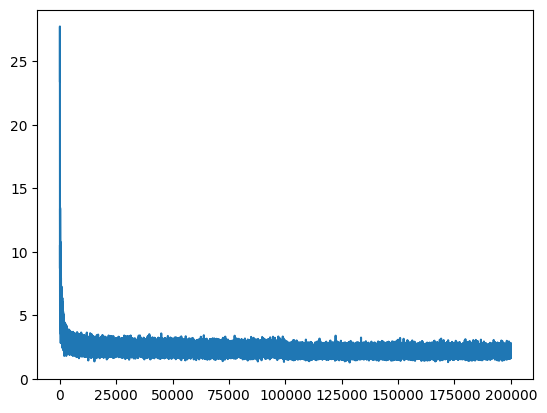

In [14]:
plt.plot(it_list,loss_list)

## 7) Evaluate on train and dev splits

Compute:
$$
\mathcal{L}_{\text{train}} = \mathrm{CE}(\text{logits}(Xtr),Ytr),
\quad
\mathcal{L}_{\text{dev}} = \mathrm{CE}(\text{logits}(Xdev),Ydev).
$$

**Exercise.**
Write an evaluation function that runs the model on a full split (no batching needed if it fits in memory) and prints the loss.



In [15]:
# TODO: evaluate train and dev losses

logits_dev, loss_dev = forward(Xdev, Ydev)

print(loss_dev)

logits, loss_te = forward(Xte, Yte)

print(loss_te) 

tensor(2.1583, grad_fn=<NllLossBackward0>)
tensor(2.1564, grad_fn=<NllLossBackward0>)


## 9) Sampling: generate names from the MLP

Maintain a context of length $T$. Initialize with:
\[
\text{context} = (0,0,\dots,0).
\]

Iterate:
1. Forward pass on the single context to get logits \(\in\mathbb{R}^{1\times V}\).
2. Convert to probabilities:
$$
p = \mathrm{softmax}(\text{logits}).
$$
3. Sample next index:
$$
i \sim \mathrm{Categorical}(p).
$$
4. Shift context and append \(i\).
5. Stop when $i=0$ (`"."`).

**Exercise.**
Generate ~20 names with a fixed generator seed.



In [16]:
# TODO: sampling loop from the trained MLP.

In [17]:

for it in range(20):
    
    names = []
    context = [0] * block_size
    
    while True:
        
      E = C[torch.tensor([context])]
      h = torch.tanh(E.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      names.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in names))

jacklony.
nihan.
dama.
alette.
navidah.
jamarcoarleedo.
mysh.
kharleison.
chy.
plyn.
erimone.
keme.
tee.
alix.
dessa.
cai.
afreem.
lacer.
minsleya.
leawn.


#### Question: I claim that the game changer in this architecture is the embeding matrix C. Do you agree?

